In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta


dask.config.set(**{'array.slicing.split_large_chunks': True})


## Import data and calculate GF

In [66]:
model_run_hist_co2mass_dict = {'CANESM5_r1p1':'CanESM5-1_historical_r1i1p1f1*', #only available for CanESM5-1, so we assume it is similar since it is forced
                      'CANESM5_r2p1':'CanESM5-1_historical_r2i1p1f1*',
                      'CANESM5_r3p1':'CanESM5-1_historical_r3i1p1f1*',
                      'CANESM5_r4p1':'CanESM5-1_historical_r4i1p1f1*',
                      'CANESM5_r5p1':'CanESM5-1_historical_r5i1p1f1*',
                      'CANESM5_r6p1':'CanESM5-1_historical_r6i1p1f1*',
                      'CANESM5_r7p1':'CanESM5-1_historical_r7i1p1f1*',
                      'CANESM5_r8p1':'CanESM5-1_historical_r8i1p1f1*',
                      'CANESM5_r9p1':'CanESM5-1_historical_r9i1p1f1*'}
model_run_control_dict = {'CANESM5_r1p1':'CanESM5_piControl_r1i1p1f1*',}


model_run_hist_co2_dict = {'CANESM5_r1p1':'CanESM5_hist-CO2_r1i1p1f1*',
                      'CANESM5_r2p1':'CanESM5_hist-CO2_r2i1p1f1*',
                      'CANESM5_r3p1':'CanESM5_hist-CO2_r3i1p1f1*',
                      'CANESM5_r4p1':'CanESM5_hist-CO2_r4i1p1f1*',
                      'CANESM5_r5p1':'CanESM5_hist-CO2_r5i1p1f1*',
                      'CANESM5_r6p1':'CanESM5_hist-CO2_r6i1p1f1*',
                      'CANESM5_r7p1':'CanESM5_hist-CO2_r7i1p1f1*',
                      'CANESM5_r8p1':'CanESM5_hist-CO2_r8i1p1f1*',
                      'CANESM5_r9p1':'CanESM5_hist-CO2_r9i1p1f1*'}

model_run_control_co2mass_dict = {'CANESM5_r1p1':'CanESM5-1_piControl_r1i1p1f1*',} #we have the mass from r1i1p1f1



In [67]:
fg_co2_hist = {}
fg_co2_pictrl = {}
nbp_hist = {}
nbp_pictrl = {}
co2_hist = {}
co2_pictrl = {}
areacello = {}
areacella = {}

In [68]:
for m in model_run_hist_dict.keys():
    fg_co2_hist[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_hist_co2_dict[m]}', use_cftime=True) #kgC/m2/s

    nbp_hist[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_hist_co2_dict[m]}', use_cftime=True) #kgC/m2/s
    co2_hist[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_hist_co2mass_dict[m]}', use_cftime=True) #kg
    
    

In [69]:
for m in model_run_control_dict.keys():
    print(m)
    print('load pi control run')
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4') #kg/m2/s 
    
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kgC/m2/s 

    co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_co2mass_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg
    
    areacello[m] = xr.open_mfdataset(f'cmip6_data/areacello_Ofx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')
    areacella[m] = xr.open_mfdataset(f'cmip6_data/areacella_fx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')


CANESM5_r1p1
load pi control run


In [72]:
for ds_dict in [nbp_hist, fg_co2_hist, co2_hist]:
    datetime.datetime.strptime(ds_dict[m].attrs['YMDH_branch_time_in_parent'],"%Y:%m:%d:%H").year 

In [73]:
## fix the times so that they line up according to the notes above

for m in nbp_hist.keys():
    for ds_dict in [nbp_hist, fg_co2_hist, co2_hist]:
        yrs = (datetime.datetime.strptime(ds_dict[m].attrs['YMDH_branch_time_in_parent'],"%Y:%m:%d:%H").year  - 
                 datetime.datetime.strptime(ds_dict['CANESM5_r1p1'].attrs['YMDH_branch_time_in_parent'],"%Y:%m:%d:%H").year)

        ds_dict[m]['time'] = ds_dict[m]['time'] + timedelta(365*yrs)


m = 'CANESM5_r1p1'
nbp_pictrl[m]['time'] = nbp_pictrl['CANESM5_r1p1']['time']- timedelta(365*3351)
fg_co2_pictrl[m]['time'] = fg_co2_pictrl['CANESM5_r1p1']['time']- timedelta(365*3351)
co2_pictrl[m]['time'] = co2_pictrl['CANESM5_r1p1']['time']- timedelta(365*4150)


In [74]:
kgCO2_to_kgC = 1/3.67

#convert kg to kg/year
for m in co2_hist.keys():
    seconds_per_yr = 60*60*24*365
    co2_hist[m]['G_atm'] = co2_hist[m]['co2mass'].diff('time')/(co2_hist[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_hist[m]['G_atm'] *= kgCO2_to_kgC
    co2_hist[m]['G_atm'].attrs = {'units':'kgC'}
    
for m in co2_pictrl.keys():
    seconds_per_yr = 60*60*24*365
    co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_pictrl[m]['G_atm'] *= kgCO2_to_kgC
    co2_pictrl[m]['G_atm'].attrs = {'units':'kgC'}

In [75]:

for m1 in model_run_hist_co2_dict.keys():
    m2 = 'CANESM5_r1p1'
    fg_co2_hist[m1] = fg_co2_hist[m1] - fg_co2_pictrl[m2]
    nbp_hist[m1] = nbp_hist[m1] - nbp_pictrl[m2]

    fg_co2_hist[m1]['fgco2'] = fg_co2_hist[m1]['fgco2']*seconds_per_yr*areacello[m2]['areacello']
    nbp_hist[m1]['nbp'] = nbp_hist[m1]['nbp']*seconds_per_yr*areacella[m2]['areacella']

In [76]:
co2_dif = {}
for m1 in co2_hist.keys():
    m2 = 'CANESM5_r1p1'
    co2_dif[m1] = co2_hist[m1]['G_atm'] - co2_pictrl[m2]['G_atm'] #kg/yr

In [77]:
#total sinks
emis_sinks = {}
for m in nbp_hist.keys():
    emis_sinks[m] = nbp_hist[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2_hist[m]['fgco2'].sum(dim = ['i','j'])
    

In [78]:
#fix the times to all be the same, weight by month and take the mean

for m in nbp_hist.keys(): 
    print(m)
    times = emis_sinks[m].time.get_index('time')
    weights = times.shift(-1, 'MS') - times.shift(1, 'MS')
    weights = xr.DataArray(weights, [('time', emis_sinks[m]['time'].values)]).astype('float')
    emis_sinks[m] =  (emis_sinks[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


CANESM5_r1p1
CANESM5_r2p1
CANESM5_r3p1
CANESM5_r4p1
CANESM5_r5p1
CANESM5_r6p1
CANESM5_r7p1
CANESM5_r8p1
CANESM5_r9p1


In [79]:
G_atm = {}
for m in co2_dif.keys():    
    times = co2_dif[m].time.get_index('time')
    weights = times.shift(-1, 'MS') - times.shift(1, 'MS')
    weights = xr.DataArray(weights, [('time', co2_dif[m]['time'].values)]).astype('float')
    G_atm[m] =  (co2_dif[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

In [80]:
for m in emis_sinks.keys():
    emis_sinks[m]['year'] = np.arange(0, len(emis_sinks[m]['year']))

In [81]:
for m in G_atm.keys():
    G_atm[m]['year'] = np.arange(0, len(G_atm[m]['year']))

In [82]:
emis_co2 = {}
for m in G_atm.keys():
    emis_co2[m] = G_atm[m] + emis_sinks[m] #use UKESM1_r1 co2 mass bc these runs don't have their own

In [83]:
emis_co2_GtC = {}
kg_to_Gt = 1e-12

for m in emis_co2.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_to_Gt
    

In [84]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')

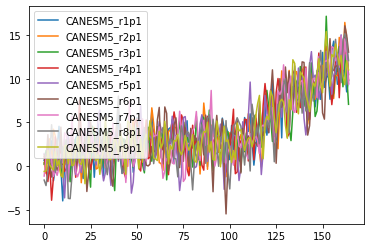

In [85]:
for m in emis_co2_GtC_ds.model.values:
    plt.plot(emis_co2_GtC_ds.sel(model = m), label = m)
    plt.legend()
    #plt.xlim(0,100)

# Save out CO2 emissions

In [87]:
emis_co2_GtC_ds.to_netcdf('Outputs/hist_co2_only_emis_profile_full.nc4')


## Plots

In [32]:
m = 'CANESM5_r1p1'

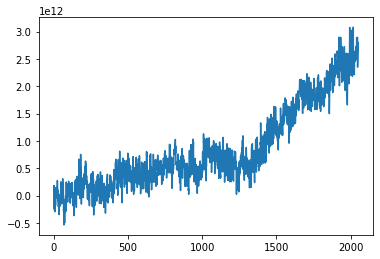

In [34]:
plt.plot(fg_co2_hist[m].sum(dim = ['i','j'])['fgco2'])

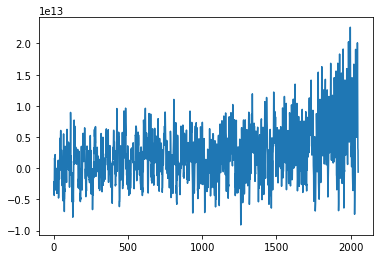

In [35]:
plt.plot(nbp_hist[m].sum(dim = ['lat','lon'])['nbp'])

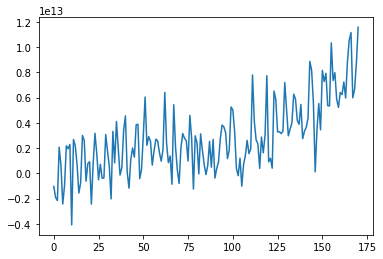

In [36]:
plt.plot(emis_sinks[m])

ValueError: 'j' not found in array dimensions ('time', 'y', 'x')

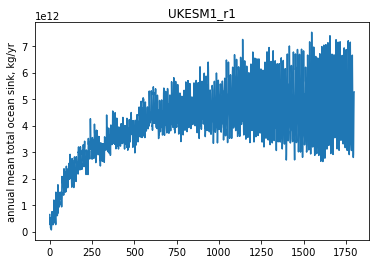

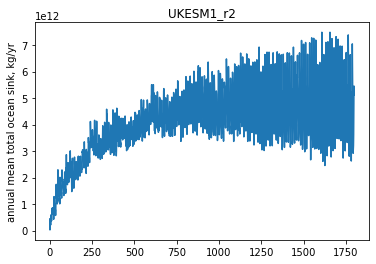

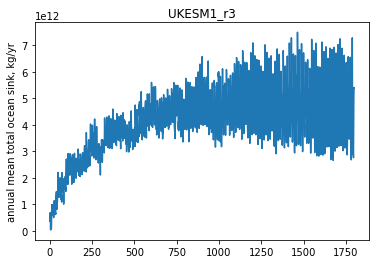

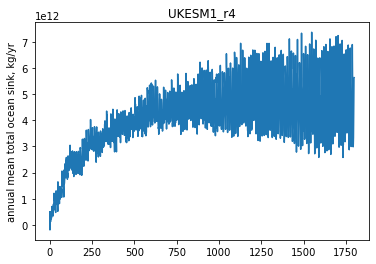

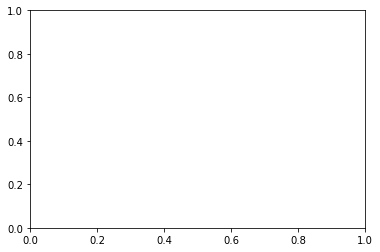

In [22]:
for m in fg_co2.keys():
    fig, ax = plt.subplots()
    plt.plot(fg_co2[m]['fgco2'].sum(dim = ['j','i']))
    plt.ylabel('annual mean total ocean sink, kg/yr')
    plt.title(m)

In [ ]:
for m in nbp.keys():
    fig, ax = plt.subplots()
    plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total land sink, kg/yr')

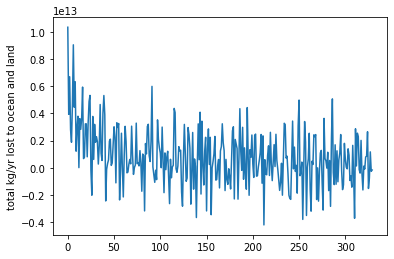

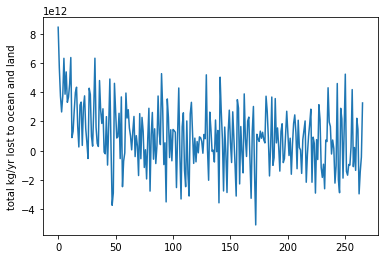

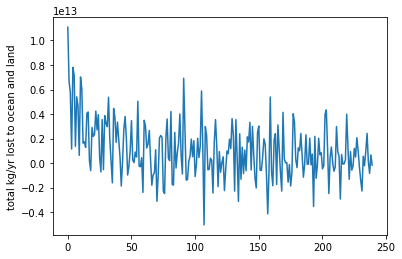

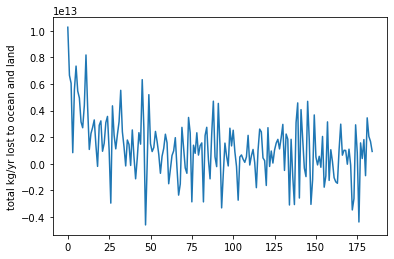

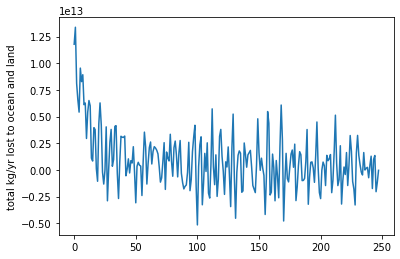

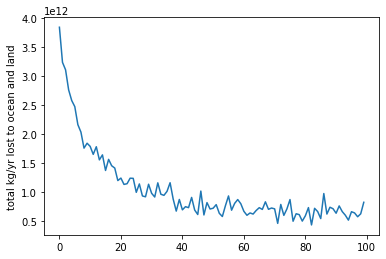

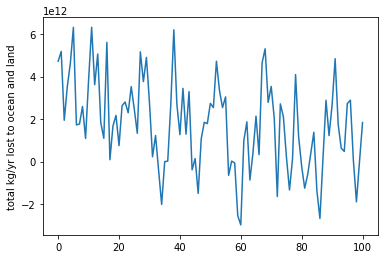

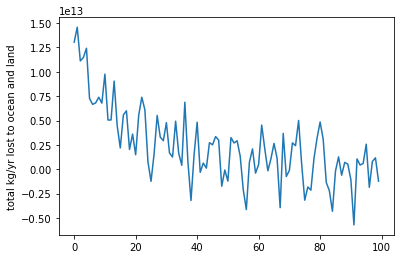

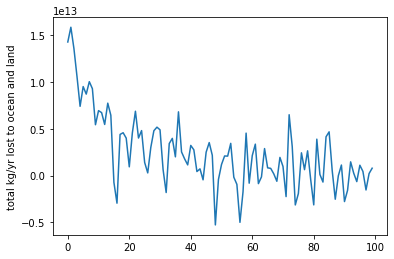

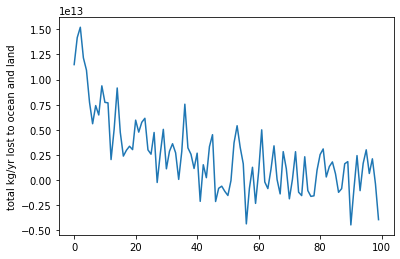

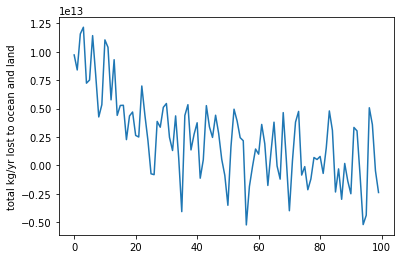

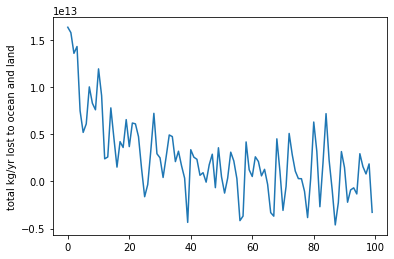

In [51]:
for m in emis_sinks.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_sinks[m])
    plt.ylabel('total kg/yr lost to ocean and land')

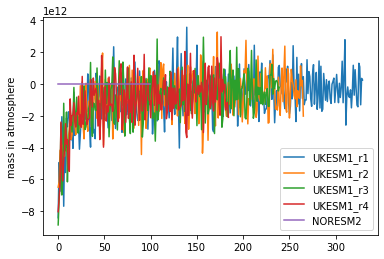

In [52]:
fig, ax = plt.subplots()
for m in G_atm.keys():
    plt.plot(G_atm[m], label = m)
    plt.ylabel('mass in atmosphere')
    plt.legend()